In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords
import string
import spacy
import el_core_news_md
nlp = el_core_news_md.load()
from greek_stemmer import GreekStemmer
stemmer = GreekStemmer()
import re

total_stop_words = (nlp.Defaults.stop_words).union(set(stopwords.words('greek')))
total_stop_words = total_stop_words.union({'ή', 'μόνον'})
total_puncts = string.punctuation + '«»–“”\xa0‘•…●\uf0b7◗♥.'
total_stop_words = list(total_stop_words) + list(string.punctuation)
#total_stop_words += [stemming(word) for word in total_stop_words]



def texts_retrieval(data_filename):
    df_texts = pd.read_csv(data_filename, index_col=None)
    return df_texts['text']



def sentences_retrieval(texts):
    documents = []
    for text in texts:
        documents += nltk.sent_tokenize(text)
    final_documents = []
    for j in range(len(documents)):   
        if re.search(r'[.!;][Α-ΩA-Z"«“]', documents[j]) != None :
            sents = re.split(r'([.!;][Α-ΩA-Z"«“])', documents[j])
            sentences = []
            for i in range(len(sents)):
                if i == 0:
                    sentences.append(sents[i])
                elif i%2 == 0:
                     sentences.append(sents[i-1][1] + sents[i])
            for sentence in sentences:
                if len(sentence)>3:
                    final_documents.append(sentence)
        else:
            if len(documents[j])>3:
                final_documents.append(documents[j])
        
    return final_documents



def filter_punctuation(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in total_puncts)

        if not all(pun):
            word = word.strip(total_puncts)
            
            if (len(word)>3):
                for punct in total_puncts:
                    word = word.replace(punct, ' ')
            else:
                for punct in total_puncts:
                    word = word.replace(punct, '')
                    
            tokens = nltk.word_tokenize(word)
            
            for token in tokens:
                filtered_words.append(token)
                
    return filtered_words



def group_numbers(words):
    new_words = []
    for word in words:
        if re.fullmatch(r'[0-9]+', word) != None :
            if int(word) >= 1800 and int(word) <= 2020:
                word = '2000'
            else:
                word = '1'
        new_words.append(word)
    return new_words



def removing_accents(word):
    """
    Removes accents from a given word.
    
    Parameters
    ----------
    word : str
        the word from which we want to remove the accents

    Returns
    -------
    str
        the word without accents
    """
    return (word.replace('ά', 'α').replace('έ', 'ε').replace('ή', 'η').replace('ί', 'ι').replace('ό', 'ο').replace('ύ', 'υ')
            .replace('ώ', 'ω').replace('ϊ', 'ι').replace('ϋ', 'υ').replace('ΐ', 'ι').replace('ΰ', 'υ'))



def stemming(word):
    """
    Implements stemming for a given word.
    
    Parameters
    ----------
    word : str
        the word that is about to be stemmed

    Returns
    -------
    str
        the stem of the given word at uppercase letters
    """
    return stemmer.stem((removing_accents(word)).upper())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
texts = texts_retrieval('../data/votana_total_texts_annotated.csv')
documents = sentences_retrieval(texts)

In [3]:
df = pd.DataFrame(columns=['Sentence'])
df['Sentence'] = documents

In [12]:
df.to_csv('../data/properties.csv', index=False)

In [4]:
len(documents)

41549

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words = set(total_stop_words)
tokenized_stop_words = nltk.word_tokenize(' '.join(total_stop_words))

class Tokenizer(object):
    def __init__(self):
        nltk.download('punkt', quiet=True, raise_on_error=True)
        self.stemmer = GreekStemmer()
        
    def _stem(self, token):
        if (token in stop_words):
            return token
        return self.stemmer.stem((removing_accents(token)).upper())
        
    def __call__(self, line):
        tokens = nltk.word_tokenize(line)
        tokens = filter_punctuation(list(tokens))
        tokens = group_numbers(tokens)
        tokens = (self._stem(token) for token in tokens)
        return tokens
    

vectorizer = TfidfVectorizer(max_df=0.5, min_df=6, stop_words=tokenized_stop_words, tokenizer=Tokenizer())
tf_idf_array = vectorizer.fit_transform(documents)

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['Δ', 'ἈΛΛ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [47]:
#print(vectorizer.stop_words_)

In [48]:
#print(vectorizer.get_feature_names())

In [23]:
from joblib import dump, load

In [7]:
dump(tf_idf_array, 'tfidf_array.joblib') 

['tfidf_array.joblib']

In [8]:
tf_idf_array = load('tfidf_array.joblib') 

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(10, 101):
    km2 = KMeans(k, max_iter=10000)
    preds = km2.fit_predict(tf_idf_array)
    silhouette_scores.append(silhouette_score(tf_idf_array, preds))

Maximum average silhouette score for k = 94


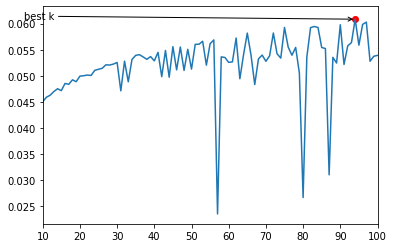

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(10, 101), silhouette_scores)
best_k = np.argmax(silhouette_scores) + 10
plt.scatter(best_k, silhouette_scores[best_k-10], color='r') 
plt.xlim([10,100])
plt.annotate("best k", xy=(best_k, silhouette_scores[best_k-10]), xytext=(5, silhouette_scores[best_k-10]),arrowprops=dict(arrowstyle="->")) 
print('Maximum average silhouette score for k =', best_k)

In [21]:
km = KMeans(best_k)
km.fit(tf_idf_array)
print(km.labels_)

[71 53 27 ...  0 20  0]


Παρατηρούμε ότι δε βελτιώθηκε ιδιαίτερα η απόδοση για μεγαλύτερο αριθμό clusters. Ίσα ίσα υπήρχαν και πολλά σκαμπανευάσματα. Οπότε φορτώνουμε το προηγούμενο μοντέλο με 57 clusters

In [12]:
dump(km, 'kmeans.joblib') 

['kmeans.joblib']

In [24]:
km = load('kmeans.joblib') 

In [25]:
km.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 57,
 'n_init': 10,
 'n_jobs': None,
 'precompute_distances': 'auto',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [18]:
df_docs = pd.read_csv('../data/properties.csv')
df_docs['Cluster'] = km.labels_
df_docs.to_csv('../data/properties.csv', index=False)

In [46]:
for i in range(len(km.labels_)):
    if km.labels_[i] == 56:
        print('~')
        print(documents[i])

~
Είναι εξαιρετικό φαρμακευτικό φυτό (φυσικό αντιβιοτικό) με αντιβακτηριακές και αντιοξειδωτικές ιδιότητες.
~
Πως να τις Μειώσουμε Αιτίες φλεγμονών – Ανοσοποιητικό – πεπτικό & φλεγμονώδης απόκριση 10 κοινά σημάδια που δείχνουν ότι έχετε χρόνια φλεγμονή Οι φλεγμονές, όταν γίνουν χρόνιες έχουν απρόβλεπτες επιπτώσεις σε ολόκληρο τον οργανισμό: Τι είναι φλεγμονή και ποιος ο ρόλος της στα αυτοάνοσα νοσήματα Φλεγμονές και Καρδιακές Παθήσεις και Το αντιοξειδωτικό & αντιφλεγμονώδες ρόδι αποφράσσει & το καρδιαγγειακό Η αντιφλεγμονώδης Διατροφική Πυραμίδα του Δρ Weil Tα πέντε ισχυρότερα αντιφλεγμονώδη βότανα!
~
Αυτό συμβαίνει επειδή το γαϊδουράγκαθο είναι αντιοξειδωτικό και εμποδίζει τη βλαπτική επίδραση των ελεύθερων ριζών στον οργανισμό.
~
Αντιοξειδωτικά: Εξουδετερώνουν τις ελεύθερες ρίζες~Εμποδίζουν την καταστροφή των κυττάρων  3.
~
Ενισχύει την παραγωγή γλουταθειόνηςΗ σιλυμαρίνη μπορεί να ενισχύσει την παραγωγή της υπερ-αντιοξειδωτικής γλουταθειόνης, η οποία βρίσκεται στην πιο ισχυρή της μορ

In [27]:
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(57):
    out = "Cluster %d:" % i
    for ind in order_centroids[i, :10]:
        out += ' %s' % terms[ind]
    print(out)

Cluster 0: ΔΙΚ ΑΠΟΚΛΕΙΣΤ ΕΥΘΥΝ ΑΝΑΦΕΡ ΧΡΗΣ 1 ΔΕΚΕΜΒΡ ΙΑΝΟΥΑΡ ΜΑΡΤ ΣΕΠΤΕΜΒΡ
Cluster 1: ΧΡΗΣΙΜΟΠΟΙ ΒΟΤΑΝ ΙΑΤΡ ΦΥΤ ΦΥΛΛ ΧΡΟΝ ΠΑΡΑΔΟΣΙΑΚ ΠΕΡΙΠΤΩΣ ΦΑΡΜΑΚ ΑΙΩΝ
Cluster 2: ΒΟΤΑΝ ΦΑΡΜΑΚ ΤΡΟΦ ΧΡΗΣ ΓΝΩΣΤ 1 ΙΔΙΟΤΗΤ ΘΕΡΑΠΕΥΤ ΦΑΡΜΑΚΕΥΤ ΜΠΑΧΑΡ
Cluster 3: ΜΕΡ ΧΡΗΣΙΜΟΠΟΙΟΥΜΕΝ ΦΥΤ 1 ΦΥΛΛ ΔΡΟΣΕΡ ΑΝΘΙΣ ΣΥΛΛΕΓ ΦΟΡ ΡΙΖ
Cluster 4: ΠΕΡΙΕΧ ΟΥΣ ΟΞ ΣΥΣΤΑΤ ΦΛΑΒΟΝΟΕΙΔ ΦΥΤ ΓΛΥΚΟΣΙΔ 1 ΤΑΝΙΝ ΕΛΑΙ
Cluster 5: ΠΕΡΙΣΣ ΙΔΙΟΤΗΤ ΒΟΤΑΝ 1 ΘΕΡΑΠΕΥΤ Δ ΘΥΜΑΡ ΧΡΗΣ ΦΥΤ ΧΡΟΝ
Cluster 6: ΣΥΜΒΟΥΛΕΥ ΓΙΑΤΡ ΠΑΝΤ ΑΛΛΑΓ ΠΑΘΗΣ ΚΑΝ ΠΕΡΙΠΤΩΣ ΔΙΑΤΡΟΦ ἙΛΛΗΝΙΚΟΥ ΔΙΑΚΡΙΣ
Cluster 7: ΚΑΡΚΙΝ ΜΑΣΤ ΜΕΛΕΤ 1 ΠΡΟΣΤΑΤ ΕΝΤΕΡ ΑΝΑΠΤΥΞ ΘΕΡΑΠΕΙ ΟΓΚ ΠΑΧΕ
Cluster 8: ΝΕΦΡ ΠΕΤΡ ΚΥΣΤ ΟΥΡΟΔΟΧ ΔΙΟΥΡΗΤ ΧΟΛ ΧΟΛΗΔΟΧ ΠΑΘΗΣ ΟΥΡΟΠΟΙΗΤ ΛΕΙΤΟΥΡΓ
Cluster 9: 1 2000 MG Χ ΓΡ Π ΓΡΑΜΜΑΡ ΕΒΔΟΜΑΔ ML ΕΚ
Cluster 10: 1 ΧΡΗΣ ΦΑΡΜΑΚ ΧΡΟΝ ΜΕΛΕΤ ΔΡ 2000 ΠΕΡΙΠΤΩΣ ΓΝΩΣΤ ΤΣΑ
Cluster 11: Δ ΒΟΤΑΝ ΙΔΙΟΤΗΤ 1 ΣΥΝΤΑΓ ΥΓΕΙ ΦΥΣΙΚ ΓΡΑΜΜΑ ΧΡΗΣΙΜΟΠΟΙΗΣ ΠΑΤ
Cluster 12: ΜΕΛΙΣΣΟΧΟΡΤ ΥΠΕΡΟΧ ΔΡΑΣ Δ ΠΟΝΟΚΕΦΑΛ ΒΟΤΑΝ ΛΕΒΑΝΤ ΚΑΤΑΝΑΛΩΣ ΝΕΥΡ ΓΝΩΣΤ
Cluster 13: ΕΙΔ ΥΠΑΡΧ 1 ΓΕΝ ΦΥΤ ΕΛΛΑΔ ΔΙΑΦΟΡ ΧΩΡ ΠΟΙΚΙΛ ΙΔΙΟΤΗΤ
Cl

* Cluster 0: 
    * Κλασική πρόταση στο τέλος για αποποίηση ευθύνης κλπ.
    
* Cluster 1: ΟΧΙ τόσο ξεκάθαρο
    * τρόποι και λόγοι χρήσης βοτάνων
    * αναφορές για διάφορες παθήσεις, ιστορικά δεδομένα και τρόπους παρασκευών
    
* Cluster 2: ΟΧΙ ξεκάθαρο
    * γενικά διάφορα για βότανα, προτάσεις υπότιτλων
    
* Cluster 3:
    * μέρη του φυτού, μέρη γεωγραφικά
    * μέρες για ετοιμασίες παρασκευών και δοσολογίες
    
* Cluster 4:
    * ουσίες και συστατικά που περιέχονται σε βότανα/ φυτά/ σκευάσματα
    
* Cluster 5: ΟΧΙ ξεκάθαρο
    * για περισσότερα παραπομπή αλλού
    * γενικά η λέξη περισσότερο
    
* Cluster 6:
    * Κλασική προτροπή στο τέλος να συμβουλευτούν οι αναγνώστες γιατρό.
    
* Cluster 7:
    * καρκίνος γενικά αλλά και συγκεκριμένα για διάφορα όργανα και μέρη του σώματος
    
* Cluster 8:
    * χοληδόχος κύστη, ήπαρ, συκώτι, ουροποιητικό σύστημα
    * πέτρες και άμμος σε αυτά
    
* Cluster 9:
    * νούμερα ως γραμμάρια, δόσεις, ύψος φυτών, χρόνια, σελίδες σε βιβλιογραφία κλπ.
    
* Cluster 10: ΟΧΙ ξεκάθαρο

* Cluster 11:
    * δείτε ακόμη και παραπομπή σε άλλο άρθρο ή δείτε μέσα στο κείμενο γενικά
    
* Cluster 12:
    * μελισσόχορτο για διάφορες παθήσεις
    
* Cluster 13:
    * είδη φυτών αλλά και άλλα είδη π.χ. ζώων, ασθενειών κλπ.
    
* Cluster 14:
    * σπόροι φυτών είτε για χρήσεις είτε για χαρακτηριστικά τους
    
* Cluster 15:
    * περιπτώσεις όπου απαιτείται προσοχή στη χρήση βοτάνων
    
* Cluster 16:
    * ύψος των φυτών και άλλες γενικές πληροφορίες για αυτά
    
* Cluster 17: ΟΧΙ ξεκάθαρο
    * διάφορες χρήσεις βοτάνων σε διάφορες παθήσεις και συνταγές
    
* Cluster 18:
    * στοιχεία επικοινωνίας στο μέιλ για διάθεση προϊόντων και περισσότερες πληροφορίες
    
* Cluster 19: ΟΧΙ ξεκάθαρο
    * γενικά φυτά
    
* Cluster 20:
    * δοσολογία την ημέρα συνήθως για ρευστά
    
* Cluster 21:
    * διαβήτης
    
* Cluster 22:
    * πίεση κυρίως αρτηριακή αλλά και σπάνια άλλων ειδών π.χ. συναισθηματική, στα μάτια, στις αρθρώσεις
    
* Cluster 23:
    * πόνος σε διάφορα σημεία του σώματος, κυρίως σε αρθρώσεις αλλά και γυναικολογικούς, στομαχικούς κ.ά.
    
* Cluster 24:
    * βιταμίνες
    
* Cluster 25:
    * γεωγραφικές περιοχές και γεωλογικά χαρακτηριστικά τους
    * χώρες, τόποι
    * σπάνια και περιοχές σώματος
    
* Cluster 26:
    * παρασκευές και ποσοτήτες κυρίως σε νερό
    
* Cluster 27:
    * ιδιότητες γενικά θεραπευτικές, φαρμακευτικές, αντιικές κλπ.
    
* Cluster 28:
    * αίμα, κυκλοφορικό σύστημα αλλά και άλλα όργανα με απλή αναφορά της ροής αίματος σε αυτά
    
* Cluster 29:
    * τελευταίες προτάσεις για το θέμα του άρθρου και την εκτύπωσή του + γενική προειδοποίηση για διατροφή
    
* Cluster 30:
    * άνθη των φυτών
    * γενικά χαρακτηριστικά τους (π.χ. χρώμα, μυρωδιά) και πιθανώς θεραπευτικές ικανότητές τους
    
* Cluster 31: ΟΧΙ ξεκάθαρο
    * συμβουλές για το τι μπορεί να κάνει ο αναγνώστης γενικά για διάφορες παθήσεις σε διάφορα βότανα
    
* Cluster 32:
    * αιθέρια έλαια και έλαια βοτάνων γενικότερα
    
* Cluster 33:
    * χαρακτηριστικά βοτάνων αλλά και γενικότερα αναφορές σε χαρακτηρισμούς
    
* Cluster 34:
    * αναφορές στην ελληνική χλωρίδα, κουζίνα και γνώση
    * αναφορές σε γνώσεις από την αρχαιότητα κυρίως για αρχαίους Έλληνες και Ρωμαίους
    
* Cluster 35:
    * βιβλιογραφικές πηγές και αναφορές σε έρευνες
    
* Cluster 36:
    * εξωτερική ή εσωτερική χρήση
    
* Cluster 37:
    * διευκρίνιση πληροφοριακού χαρακτήρα σελίδας
    
* CLuster 38: ΟΧΙ τόσο ξεκάθαρο
    * το ανθρώπινο σώμα γενικά, όσον αφορά περιοχές εφαρμογής κρεμών κλπ., για αποτοξίνωση, χαλάρωση, ισορροπία κλπ.
    
* Cluster 39: ΟΧΙ τόσο ξεκάθαρο
    * παρενέργειες από υπερδοσολογία
    * γενικότερα με βάση τη λέξη μεγάλο (μεγάλη χρησιμότητα, μεγάλο χρονικό διάτημα κλπ.)
    
* Cluster 40:
    * νευρικό σύστημα
    
* Cluster 41:
    * αναφορές σε κυτταρικό επίπεδο για διάφορα όργανα και συχνά σε καρκινικά κύτταρα
    
* Cluster 42:
    * η δράση διάφορων ουσιών και βοτάνων
    * συνήθως αντιμικροβιακή, αντιβακτηριδιακή, αντιική
    
* Cluster 43:
    * βότανο βασιλικός, βασιλικός πολτός και αναφορές σε βασιλιάδες
    
* Cluster 44:
    * φύλλα διάφορων φυτών, τα μορφολογικά χαρακτηριστικά τους, οι φαρμακευτικές ιδιότητές τους και χρήσεις τους
    
* Cluster 45:
    * επίπεδα χοληστερόλης, τριγλυκεριδίων, σακχάρου, κορτιζόλης και διάφορων ορμονών
    
* Cluster 46:
    * μέρη ενός φυτόυ (βλαστοί, φύλλα, άνθη) και τι τα κάνουμε
    
* Cluster 47: ΟΧΙ ξεκάθαρο
    * διάφορες χρήσεις
    
* Cluster 48:
    * αναφορά σε παρενέργειες ή απουσία αυτών
    
* Cluster 49:
    * ονομασία φυτών και συχνά προέλευση αυτής
    
* Cluster 50:
    * οικογένειες και κατηγορίες φυτών
    
* Cluster 51:
    * γεύση βοτάνων
    
* Cluster 52: ΟΧΙ ξεκάθαρο
    * θεραπείες για διάφορες παθήσεις
    
* Cluster 53:
    * ανοσοποιητικό σύστημα
    
* Cluster 54: ΟΧΙ ξεκάθαρο
    * με βάση τη λέξη καλό (καλή λειτουργία, κάνει καλό κλπ.)
    
* Cluster 55: ΟΧΙ ξεκάθαρο
    * πού βοηθάει το κάθε βότανο
    
* Cluster 56:
    * ανιοξειδωτική δράση βοτάνων